In [58]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import  permutation_importance
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import SGDOneClassSVM

rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=7,
    n_jobs=-1,
    random_state=42)

In [45]:
data = pd.read_csv('../dset/kaggle_river_playground/sample_submission.csv')

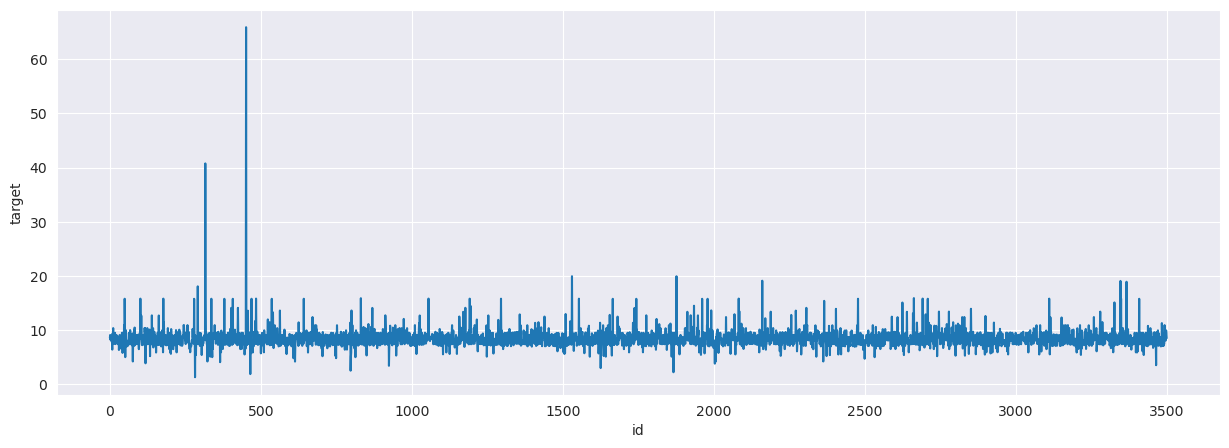

In [46]:
plt.figure(figsize = (15, 5))
plt.xlabel('id')
plt.ylabel('target')
sns.lineplot(data=data, x='id', y='target')
plt.show()

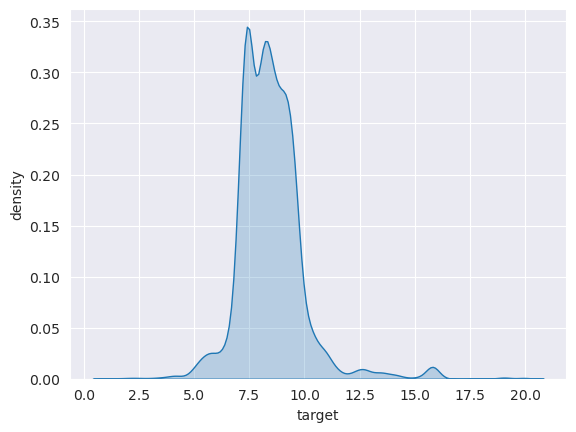

In [47]:
plt.xlabel('target')
plt.ylabel('density')
sns.kdeplot(data[data.target<20]['target'], fill=True)
plt.show()

In [48]:
corrmat = data.corr()
largest_corr = corrmat.nlargest(5, 'target')['target'].index
print(largest_corr)

Index(['target', 'O2_1', 'O2_2', 'O2_6', 'NH4_5'], dtype='object')


/home/alp/anaconda3/envs/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


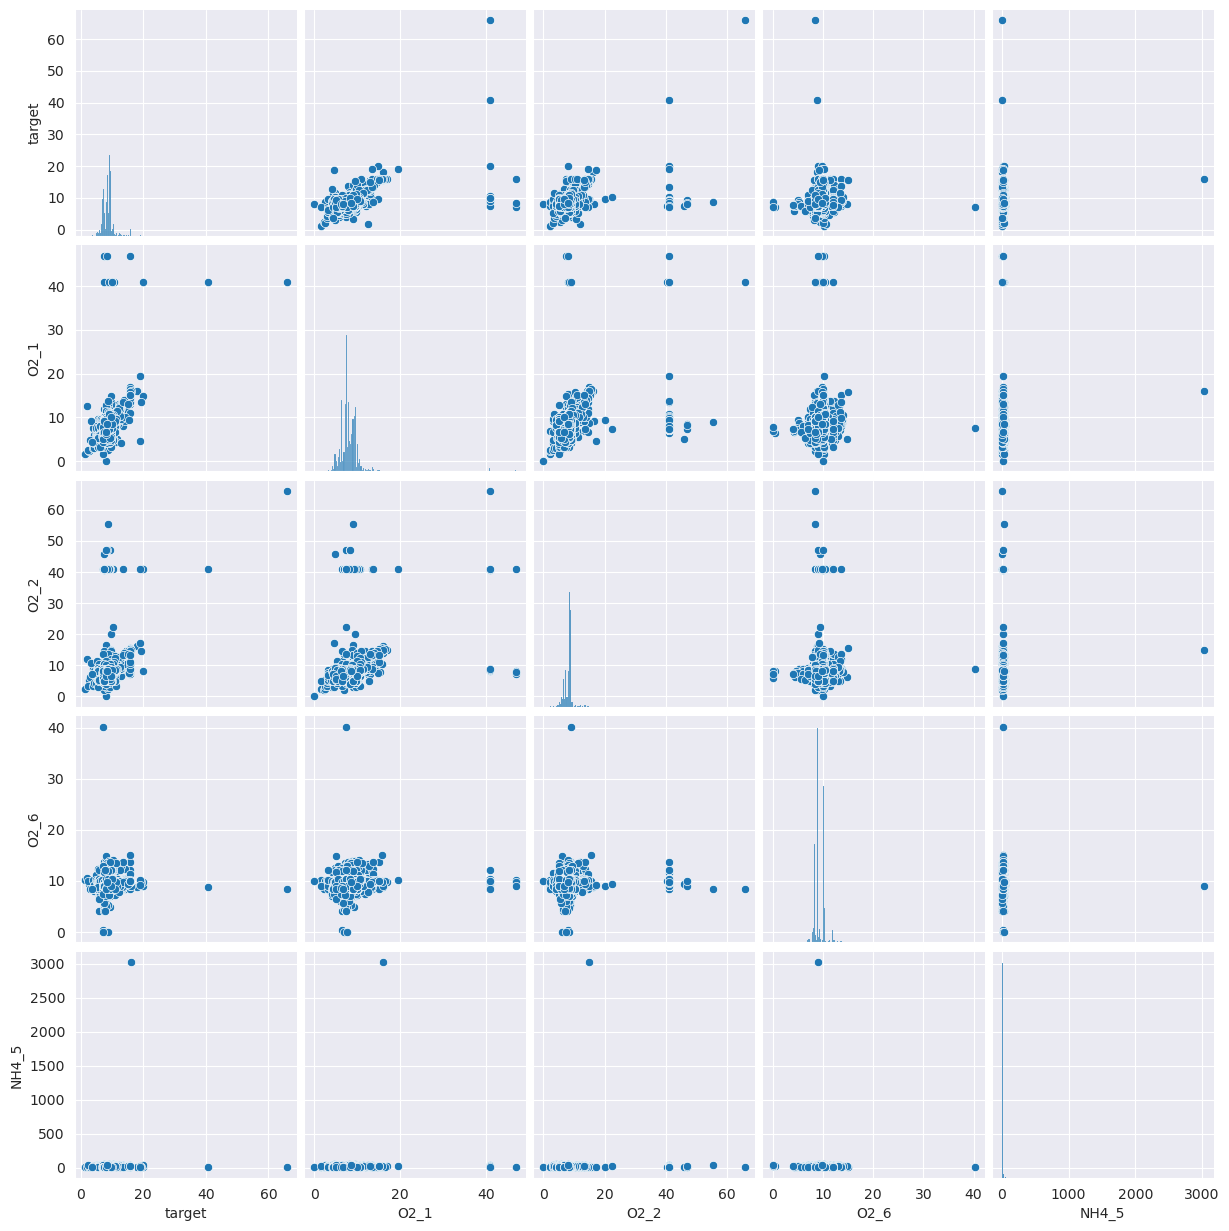

In [49]:
sns.pairplot(data[largest_corr])

In [50]:
train_data = data[(data.target > 30)]
remains = data[(data.target <= 30)]

x_train, x_test, y_train, y_test = train_test_split(remains.drop(['target'], axis=1), remains.loc[:, 'target'], test_size=700, random_state=1);
data_train = pd.concat([x_train, y_train], axis=1)
data_train = pd.concat([data_train, train_data], axis=0)
x_train = data_train.drop('target', axis=1)
y_train = data_train.loc[:, 'target']

print(x_train.shape, x_test.shape)

(2800, 36) (700, 36)


In [51]:
X = data.drop(['id', 'target'], axis=1)
y = data.loc[:, 'target']

mi_score = mutual_info_regression(X, y)
mi_score = pd.Series(mi_score, name="MI score", index=X.columns)
mi_score = mi_score.sort_values(ascending=False)
print(mi_score)

O2_1      0.678195
O2_2      0.464320
NO3_2     0.169142
O2_4      0.152808
NO2_3     0.148818
NH4_1     0.143611
O2_3      0.142565
BOD5_2    0.136594
NO2_1     0.136381
BOD5_1    0.130691
NO3_1     0.126937
O2_6      0.125471
O2_7      0.120498
NH4_5     0.116229
BOD5_5    0.115922
NH4_4     0.115795
NH4_2     0.112615
NO2_2     0.107325
O2_5      0.104794
NO2_7     0.100194
NO2_5     0.098066
BOD5_4    0.095150
NH4_7     0.090595
NO3_5     0.090198
NO3_6     0.085224
NH4_3     0.082689
BOD5_3    0.081993
NO3_7     0.079627
BOD5_6    0.079215
NO3_3     0.078727
NO3_4     0.076204
NO2_4     0.066866
NH4_6     0.065084
NO2_6     0.059208
BOD5_7    0.000000
Name: MI score, dtype: float64


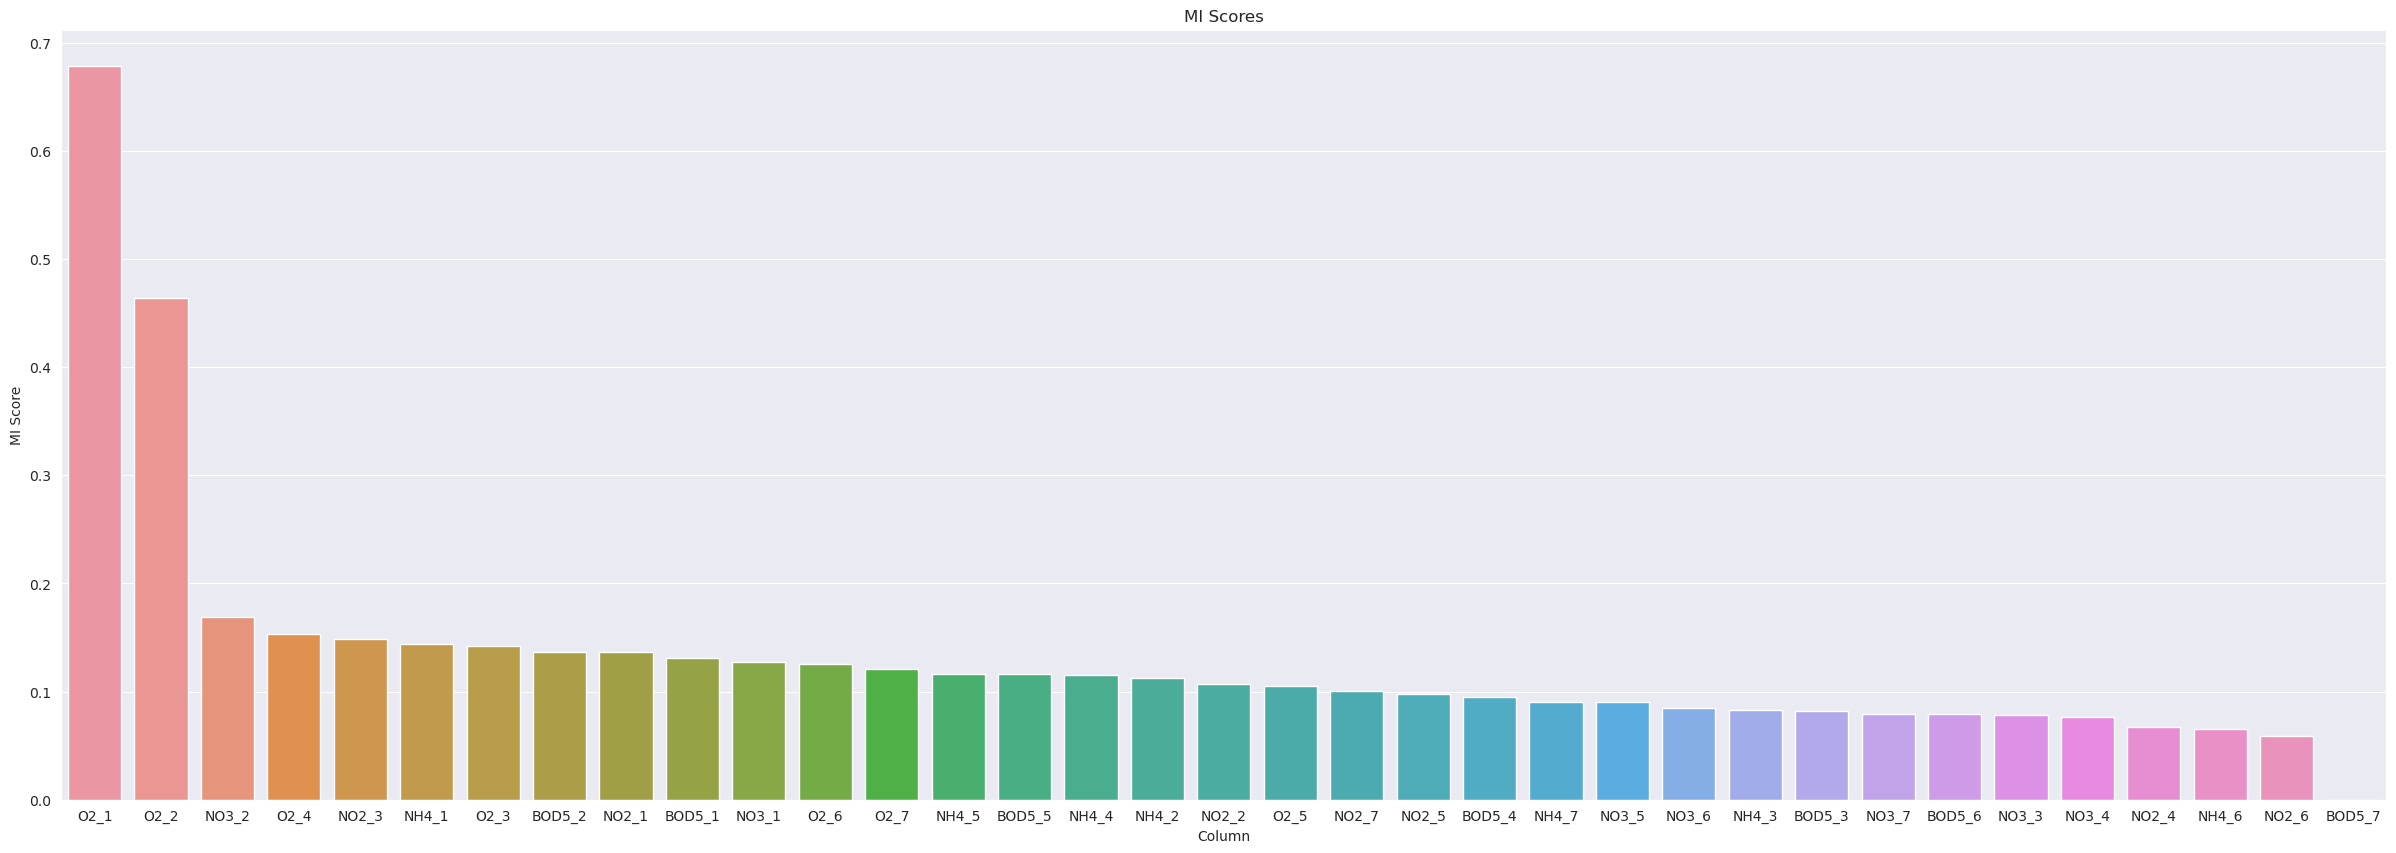

In [52]:
plt.figure(figsize=(30,10))
plt.title('MI Scores')
ax = sns.barplot(x=mi_score.index,y=mi_score.values)
ax.set_xticklabels(mi_score.index)
plt.xlabel('Column')
plt.ylabel('MI Score')
plt.show()

In [53]:
rf.fit(X, y)
importance = rf.feature_importances_
cols = X.columns
info = dict()
for i in range(len(cols)):
    info[cols[i]] = importance[i]

print(info)

{'O2_1': 0.510242131965826, 'O2_2': 0.28762549065295057, 'O2_3': 0.0026911520751446818, 'O2_4': 0.00692334930170189, 'O2_5': 0.005251489526629429, 'O2_6': 0.0035707569253078603, 'O2_7': 0.003826189675266492, 'NH4_1': 0.004865785452979363, 'NH4_2': 0.004028682778721372, 'NH4_3': 0.0032994127879192496, 'NH4_4': 0.003186462461765148, 'NH4_5': 0.0042123075658001465, 'NH4_6': 0.0093702868114113, 'NH4_7': 0.001669343655072952, 'NO2_1': 0.003208782489261178, 'NO2_2': 0.010306253374861931, 'NO2_3': 0.0025514985816501435, 'NO2_4': 0.0023222475916975546, 'NO2_5': 0.0032472325438998783, 'NO2_6': 0.005427981368869007, 'NO2_7': 0.0034627356815102946, 'NO3_1': 0.002443677548009965, 'NO3_2': 0.002843220339730728, 'NO3_3': 0.0028655478829749557, 'NO3_4': 0.002444210677857347, 'NO3_5': 0.0026828272608995555, 'NO3_6': 0.006530943461614802, 'NO3_7': 0.0051772033868603485, 'BOD5_1': 0.0031794311408640994, 'BOD5_2': 0.0032261002665061856, 'BOD5_3': 0.004046248355881684, 'BOD5_4': 0.002924408925916154, 'BOD

In [54]:
svm = SGDOneClassSVM(nu=0.01)
anom = pd.DataFrame()
anom['svm'] = svm.fit_predict(data.drop(['id'], axis=1))
#print(np.where(data['svm']==-1))
print(np.count_nonzero(anom['svm']==-1))

0


In [57]:
iso = IsolationForest(contamination=0.005)
anom['iso'] = iso.fit_predict(data.drop(['id'], axis=1))
print(np.count_nonzero(anom['iso'] == -1))

18


In [60]:
lof = LocalOutlierFactor(contamination=0.005)
anom['lof'] = lof.fit_predict(data.drop(['id'], axis=1))
print(np.count_nonzero((anom['lof']==-1)))

18


In [66]:
rows_to_remove = []

for i in range(len(anom['svm'])):
    if anom['svm'][i] == -1:
        rows_to_remove.append(i)
    if anom['iso'][i] == -1:
        if i not in rows_to_remove:
            rows_to_remove.append(i)
    if anom['lof'][i] == -1:
        if i not in rows_to_remove:
            rows_to_remove.append(i)

print(rows_to_remove)
#rows_to_remove = np.union1d(np.union1d(np.where(anom['svm']==-1),np.where(anom['iso']==-1)),np.where(anom['lof']==-1))

[46, 152, 320, 451, 457, 564, 596, 694, 712, 831, 863, 939, 1064, 1074, 1145, 1146, 1152, 1177, 1473, 1826, 1952, 1989, 2152, 2233, 2436, 2513, 2558, 2588, 2662, 2856, 2860, 3166, 3252, 3393, 3402]


In [67]:
data_dropped = data.drop(index=rows_to_remove)


In [68]:
data['target']=data['target'].clip(7,20)
data['target'].describe()

count    3500.000000
mean        8.521051
std         1.437272
min         7.000000
25%         7.470000
50%         8.280000
75%         9.110000
max        20.000000
Name: target, dtype: float64